# GAN Project, Deep Learning week 5 - Simple GAN
Prepared by Ryan Birmingham
Data from https://www.kaggle.com/competitions/gan-getting-started/overview/description
(This is part 1 of 2; in part 2, a cycle gan is explored)

# About this Project

We have a large number of photos, and a smaller number of monet works. We're trying to generate a large number of monet styled works. The simplest method would be to make something which simply generates monet works. So setting up a simple monet GAN here. 

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# kaggle input files, autopopulated
! ls /kaggle/input/gan-getting-started/


monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


## Analysis of Inputs
First, let's look in the directories to see what kind of things we have, and wc them to get counts.

In [2]:
! ls /kaggle/input/gan-getting-started/monet_jpg | head

000c1e3bff.jpg
011835cfbf.jpg
0260d15306.jpg
049e293b93.jpg
05144e306f.jpg
052a77c020.jpg
058f878b7c.jpg
05b493ff42.jpg
064487d630.jpg
066fe4cbaa.jpg
ls: write error: Broken pipe


In [3]:
ls -l /kaggle/input/gan-getting-started/monet_jpg | wc -l

301


In [4]:
! ls /kaggle/input/gan-getting-started/photo_jpg | head

00068bc07f.jpg
000910d219.jpg
000ded5c41.jpg
00104fd531.jpg
001158d595.jpg
0033c5f971.jpg
0039ebb598.jpg
003aab6fdd.jpg
003c6c30e0.jpg
00479e2a21.jpg
ls: write error: Broken pipe


In [5]:
ls -l /kaggle/input/gan-getting-started/photo_jpg | wc -l

7039


In [6]:
import os
from PIL import Image


monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

monet_sizes = []
photo_sizes = []

for filename in os.scandir(monet_dir):
    if filename.is_file():
        with Image.open(filename.path) as img:
            monet_sizes.append(img.size)
            
for filename in os.scandir(photo_dir):
    if filename.is_file():
        with Image.open(filename.path) as img:
            photo_sizes.append(img.size)

showing /kaggle/input/gan-getting-started/monet_jpg/f04c9d8e34.jpg


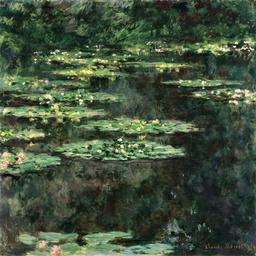

showing /kaggle/input/gan-getting-started/monet_jpg/599098859e.jpg


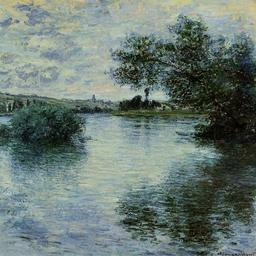

In [7]:
import random
from IPython.display import Image

for filename in os.scandir(monet_dir):
    if filename.is_file():
        if random.random() > 0.98:
            print("showing", filename.path)
            display(Image(filename=filename.path))

showing /kaggle/input/gan-getting-started/photo_jpg/3c327deaca.jpg


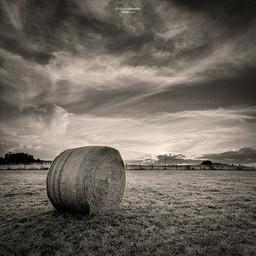

showing /kaggle/input/gan-getting-started/photo_jpg/1d5aa09f6b.jpg


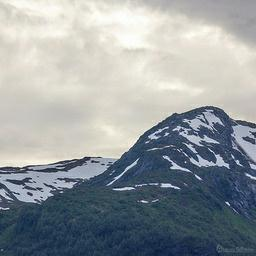

showing /kaggle/input/gan-getting-started/photo_jpg/aa0485a59f.jpg


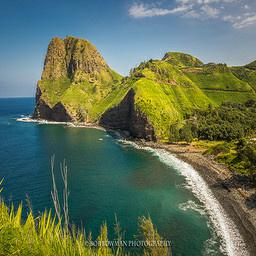

showing /kaggle/input/gan-getting-started/photo_jpg/2d5082427e.jpg


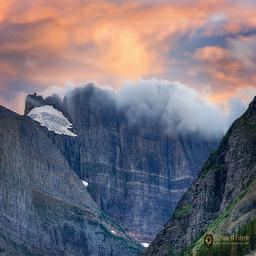

In [8]:
for filename in os.scandir(photo_dir):
    if filename.is_file():
        if random.random() > 0.999:
            print("showing", filename.path)
            display(Image(filename=filename.path))


# Data as Inputs
We know the images are 256x256, and jpg. Let's make a keras dataset out of them.

In [9]:
import tensorflow as tf
monet_data = tf.keras.utils.image_dataset_from_directory(monet_dir, label_mode=None, image_size=(256, 256), batch_size=32)
photo_data = tf.keras.utils.image_dataset_from_directory(photo_dir, label_mode=None, image_size=(256, 256), batch_size=32)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [10]:
from tensorflow import keras
from tensorflow.keras import layers

# Discriminator, adapted from https://keras.io/examples/generative/dcgan_overriding_train_step/
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 flatten (Flatten)           (None, 16384)           

In [11]:
# Generator, adapted from https://keras.io/examples/generative/dcgan_overriding_train_step/

generator = tf.keras.Sequential(
    [
        keras.Input(shape=(64,)),
        layers.Dense(8 * 8 * 32),
        layers.Reshape((8, 8, 32)),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              133120    
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       16416     
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       32832     
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0 

In [12]:
# heavily borrowed from https://keras.io/examples/generative/dcgan_overriding_train_step/

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=32):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [13]:
# normalize nad downsize for gan
monet_data = monet_data.map(lambda x: x / 255.0)
monet_data = monet_data.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))

In [14]:
epochs = 128

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=64)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    monet_data, epochs=epochs, callbacks=[GANMonitor(num_img=2, latent_dim=64)]
)

Epoch 1/128
10/10 [==============================] - 29s 3s/step - d_loss: 0.6736 - g_loss: 0.7648
Epoch 2/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.6088 - g_loss: 0.8465
Epoch 3/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.5066 - g_loss: 1.0515
Epoch 4/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.4035 - g_loss: 1.3057
Epoch 5/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.3356 - g_loss: 1.5272
Epoch 6/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.2223 - g_loss: 2.1272
Epoch 7/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.2090 - g_loss: 2.4766
Epoch 8/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.2340 - g_loss: 2.0424
Epoch 9/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.1784 - g_loss: 2.4747
Epoch 10/128
10/10 [==============================] - 26s 3s/step - d_loss: 0.1535 - g_loss: 2.6029
Epoch 11/

showing /kaggle/working/generated_img_127_0.png


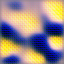

showing /kaggle/working/generated_img_086_1.png


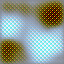

showing /kaggle/working/generated_img_007_1.png


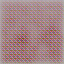

showing /kaggle/working/generated_img_007_0.png


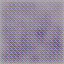

showing /kaggle/working/generated_img_055_1.png


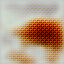

showing /kaggle/working/generated_img_081_0.png


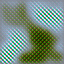

showing /kaggle/working/generated_img_040_1.png


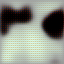

showing /kaggle/working/generated_img_091_1.png


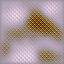

showing /kaggle/working/generated_img_064_0.png


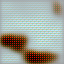

showing /kaggle/working/generated_img_014_1.png


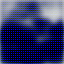

showing /kaggle/working/generated_img_039_1.png


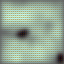

showing /kaggle/working/generated_img_061_1.png


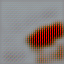

showing /kaggle/working/generated_img_045_0.png


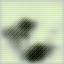

showing /kaggle/working/generated_img_040_0.png


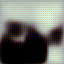

showing /kaggle/working/generated_img_044_0.png


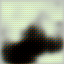

showing /kaggle/working/generated_img_119_1.png


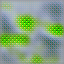

showing /kaggle/working/generated_img_110_1.png


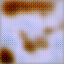

showing /kaggle/working/generated_img_028_1.png


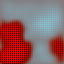

showing /kaggle/working/generated_img_120_1.png


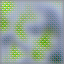

showing /kaggle/working/generated_img_050_0.png


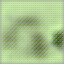

showing /kaggle/working/generated_img_037_1.png


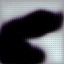

showing /kaggle/working/generated_img_092_0.png


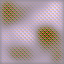

showing /kaggle/working/generated_img_058_1.png


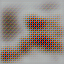

showing /kaggle/working/generated_img_080_1.png


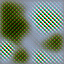

showing /kaggle/working/generated_img_024_1.png


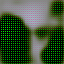

showing /kaggle/working/generated_img_023_0.png


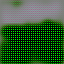

showing /kaggle/working/generated_img_081_1.png


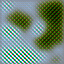

showing /kaggle/working/generated_img_012_1.png


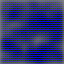

showing /kaggle/working/generated_img_067_0.png


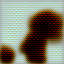

showing /kaggle/working/generated_img_058_0.png


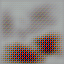

showing /kaggle/working/generated_img_032_1.png


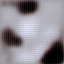

showing /kaggle/working/generated_img_029_1.png


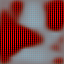

showing /kaggle/working/generated_img_078_0.png


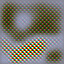

showing /kaggle/working/generated_img_102_0.png


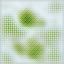

showing /kaggle/working/generated_img_085_0.png


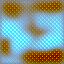

showing /kaggle/working/generated_img_005_0.png


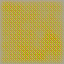

showing /kaggle/working/generated_img_034_0.png


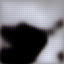

showing /kaggle/working/generated_img_068_1.png


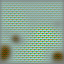

showing /kaggle/working/generated_img_119_0.png


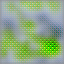

showing /kaggle/working/generated_img_010_1.png


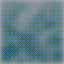

showing /kaggle/working/generated_img_029_0.png


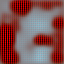

showing /kaggle/working/generated_img_051_0.png


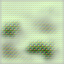

showing /kaggle/working/generated_img_016_1.png


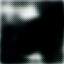

showing /kaggle/working/generated_img_122_0.png


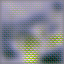

showing /kaggle/working/generated_img_074_0.png


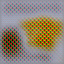

showing /kaggle/working/generated_img_082_1.png


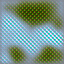

showing /kaggle/working/generated_img_009_0.png


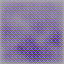

showing /kaggle/working/generated_img_001_0.png


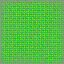

showing /kaggle/working/generated_img_065_0.png


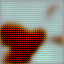

showing /kaggle/working/generated_img_080_0.png


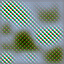

showing /kaggle/working/generated_img_108_0.png


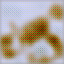

showing /kaggle/working/generated_img_079_1.png


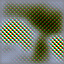

showing /kaggle/working/generated_img_003_1.png


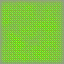

showing /kaggle/working/generated_img_017_1.png


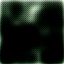

showing /kaggle/working/generated_img_113_1.png


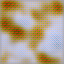

showing /kaggle/working/generated_img_071_0.png


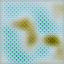

showing /kaggle/working/generated_img_011_0.png


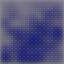

showing /kaggle/working/generated_img_101_1.png


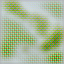

showing /kaggle/working/generated_img_086_0.png


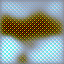

showing /kaggle/working/generated_img_056_0.png


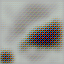

showing /kaggle/working/generated_img_108_1.png


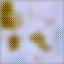

showing /kaggle/working/generated_img_097_1.png


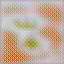

showing /kaggle/working/generated_img_002_0.png


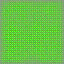

showing /kaggle/working/generated_img_006_0.png


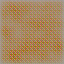

showing /kaggle/working/generated_img_115_0.png


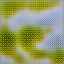

showing /kaggle/working/generated_img_116_0.png


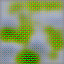

showing /kaggle/working/generated_img_063_1.png


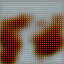

showing /kaggle/working/generated_img_051_1.png


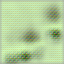

showing /kaggle/working/generated_img_038_1.png


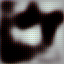

showing /kaggle/working/generated_img_112_1.png


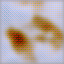

showing /kaggle/working/generated_img_125_0.png


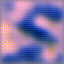

showing /kaggle/working/generated_img_009_1.png


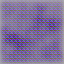

showing /kaggle/working/generated_img_037_0.png


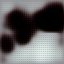

showing /kaggle/working/generated_img_076_0.png


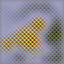

showing /kaggle/working/generated_img_019_0.png


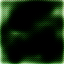

showing /kaggle/working/generated_img_100_0.png


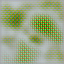

showing /kaggle/working/generated_img_099_0.png


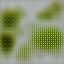

showing /kaggle/working/generated_img_064_1.png


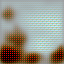

showing /kaggle/working/generated_img_063_0.png


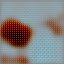

showing /kaggle/working/generated_img_098_0.png


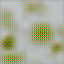

showing /kaggle/working/generated_img_013_0.png


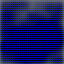

showing /kaggle/working/generated_img_022_1.png


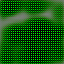

showing /kaggle/working/generated_img_114_1.png


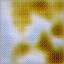

showing /kaggle/working/generated_img_114_0.png


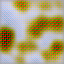

showing /kaggle/working/generated_img_102_1.png


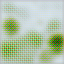

showing /kaggle/working/generated_img_094_1.png


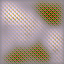

showing /kaggle/working/generated_img_042_1.png


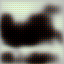

showing /kaggle/working/generated_img_004_1.png


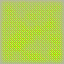

showing /kaggle/working/generated_img_030_0.png


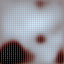

showing /kaggle/working/generated_img_015_1.png


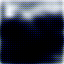

showing /kaggle/working/generated_img_095_1.png


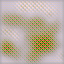

showing /kaggle/working/generated_img_060_0.png


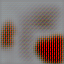

showing /kaggle/working/generated_img_028_0.png


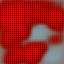

showing /kaggle/working/generated_img_026_1.png


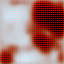

showing /kaggle/working/generated_img_088_1.png


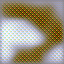

showing /kaggle/working/generated_img_045_1.png


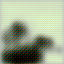

showing /kaggle/working/generated_img_107_0.png


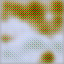

showing /kaggle/working/generated_img_072_1.png


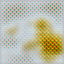

showing /kaggle/working/generated_img_025_1.png


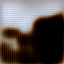

showing /kaggle/working/generated_img_050_1.png


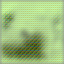

showing /kaggle/working/generated_img_046_1.png


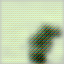

showing /kaggle/working/generated_img_062_1.png


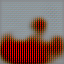

showing /kaggle/working/generated_img_112_0.png


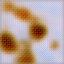

showing /kaggle/working/generated_img_103_1.png


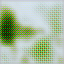

showing /kaggle/working/generated_img_035_1.png


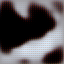

showing /kaggle/working/generated_img_089_1.png


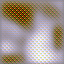

showing /kaggle/working/generated_img_005_1.png


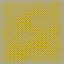

showing /kaggle/working/generated_img_068_0.png


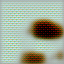

showing /kaggle/working/generated_img_025_0.png


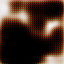

showing /kaggle/working/generated_img_079_0.png


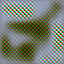

showing /kaggle/working/generated_img_004_0.png


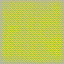

showing /kaggle/working/generated_img_047_0.png


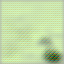

showing /kaggle/working/generated_img_023_1.png


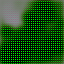

showing /kaggle/working/generated_img_105_0.png


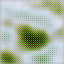

showing /kaggle/working/generated_img_109_1.png


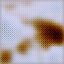

showing /kaggle/working/generated_img_083_0.png


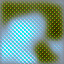

showing /kaggle/working/generated_img_075_0.png


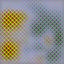

showing /kaggle/working/generated_img_087_0.png


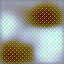

showing /kaggle/working/generated_img_083_1.png


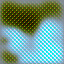

showing /kaggle/working/generated_img_098_1.png


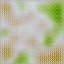

showing /kaggle/working/generated_img_052_1.png


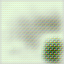

showing /kaggle/working/generated_img_021_0.png


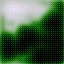

showing /kaggle/working/generated_img_126_0.png


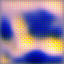

showing /kaggle/working/generated_img_056_1.png


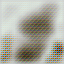

showing /kaggle/working/generated_img_084_0.png


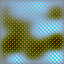

showing /kaggle/working/generated_img_059_1.png


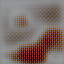

showing /kaggle/working/generated_img_097_0.png


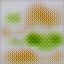

showing /kaggle/working/generated_img_041_1.png


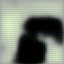

showing /kaggle/working/generated_img_020_0.png


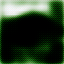

showing /kaggle/working/generated_img_124_1.png


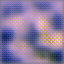

showing /kaggle/working/generated_img_008_0.png


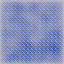

showing /kaggle/working/generated_img_070_0.png


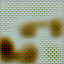

showing /kaggle/working/generated_img_016_0.png


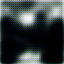

showing /kaggle/working/generated_img_057_0.png


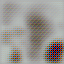

showing /kaggle/working/generated_img_012_0.png


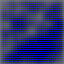

showing /kaggle/working/generated_img_022_0.png


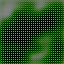

showing /kaggle/working/generated_img_038_0.png


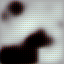

showing /kaggle/working/generated_img_111_1.png


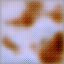

showing /kaggle/working/generated_img_091_0.png


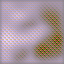

showing /kaggle/working/generated_img_041_0.png


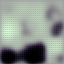

showing /kaggle/working/generated_img_003_0.png


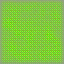

showing /kaggle/working/generated_img_031_0.png


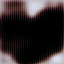

showing /kaggle/working/generated_img_117_1.png


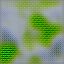

showing /kaggle/working/generated_img_069_1.png


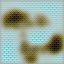

showing /kaggle/working/generated_img_067_1.png


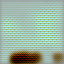

showing /kaggle/working/generated_img_053_1.png


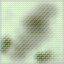

showing /kaggle/working/generated_img_055_0.png


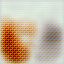

showing /kaggle/working/generated_img_035_0.png


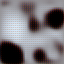

showing /kaggle/working/generated_img_006_1.png


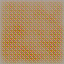

showing /kaggle/working/generated_img_049_0.png


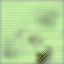

showing /kaggle/working/generated_img_106_0.png


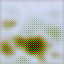

showing /kaggle/working/generated_img_053_0.png


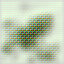

showing /kaggle/working/generated_img_033_0.png


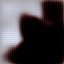

showing /kaggle/working/generated_img_013_1.png


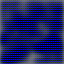

showing /kaggle/working/generated_img_090_1.png


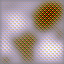

showing /kaggle/working/generated_img_065_1.png


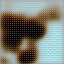

showing /kaggle/working/generated_img_042_0.png


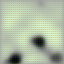

showing /kaggle/working/generated_img_021_1.png


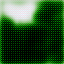

showing /kaggle/working/generated_img_115_1.png


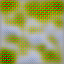

showing /kaggle/working/generated_img_032_0.png


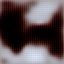

showing /kaggle/working/generated_img_077_0.png


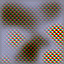

showing /kaggle/working/generated_img_118_0.png


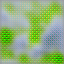

showing /kaggle/working/generated_img_027_0.png


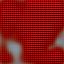

showing /kaggle/working/generated_img_036_1.png


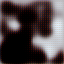

showing /kaggle/working/generated_img_030_1.png


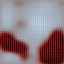

showing /kaggle/working/generated_img_072_0.png


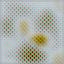

showing /kaggle/working/generated_img_014_0.png


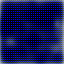

showing /kaggle/working/generated_img_008_1.png


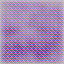

showing /kaggle/working/generated_img_103_0.png


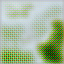

showing /kaggle/working/generated_img_092_1.png


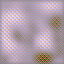

showing /kaggle/working/generated_img_043_0.png


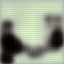

showing /kaggle/working/generated_img_071_1.png


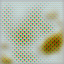

showing /kaggle/working/generated_img_105_1.png


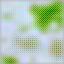

showing /kaggle/working/generated_img_118_1.png


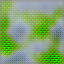

showing /kaggle/working/generated_img_082_0.png


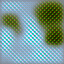

showing /kaggle/working/generated_img_002_1.png


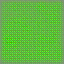

showing /kaggle/working/generated_img_066_0.png


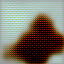

showing /kaggle/working/generated_img_094_0.png


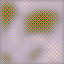

showing /kaggle/working/generated_img_017_0.png


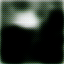

showing /kaggle/working/generated_img_109_0.png


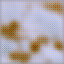

showing /kaggle/working/generated_img_126_1.png


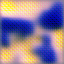

showing /kaggle/working/generated_img_000_0.png


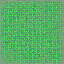

showing /kaggle/working/generated_img_048_0.png


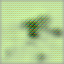

showing /kaggle/working/generated_img_059_0.png


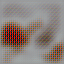

showing /kaggle/working/generated_img_127_1.png


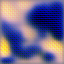

showing /kaggle/working/generated_img_104_1.png


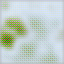

showing /kaggle/working/generated_img_078_1.png


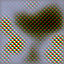

showing /kaggle/working/generated_img_122_1.png


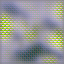

showing /kaggle/working/generated_img_046_0.png


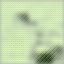

showing /kaggle/working/generated_img_087_1.png


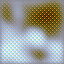

showing /kaggle/working/generated_img_093_1.png


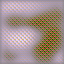

showing /kaggle/working/generated_img_011_1.png


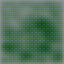

showing /kaggle/working/generated_img_116_1.png


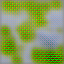

showing /kaggle/working/generated_img_043_1.png


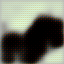

showing /kaggle/working/generated_img_018_0.png


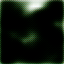

showing /kaggle/working/generated_img_000_1.png


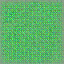

showing /kaggle/working/generated_img_093_0.png


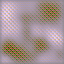

showing /kaggle/working/generated_img_107_1.png


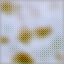

showing /kaggle/working/generated_img_027_1.png


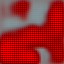

showing /kaggle/working/generated_img_073_0.png


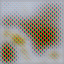

showing /kaggle/working/generated_img_070_1.png


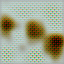

showing /kaggle/working/generated_img_073_1.png


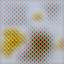

showing /kaggle/working/generated_img_121_0.png


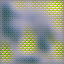

showing /kaggle/working/generated_img_001_1.png


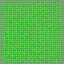

showing /kaggle/working/generated_img_034_1.png


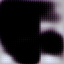

showing /kaggle/working/generated_img_057_1.png


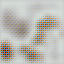

showing /kaggle/working/generated_img_123_0.png


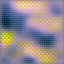

showing /kaggle/working/generated_img_026_0.png


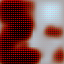

showing /kaggle/working/generated_img_010_0.png


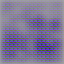

showing /kaggle/working/generated_img_048_1.png


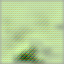

showing /kaggle/working/generated_img_113_0.png


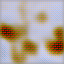

showing /kaggle/working/generated_img_049_1.png


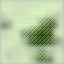

showing /kaggle/working/generated_img_077_1.png


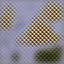

showing /kaggle/working/generated_img_106_1.png


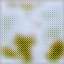

showing /kaggle/working/generated_img_062_0.png


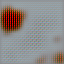

showing /kaggle/working/generated_img_069_0.png


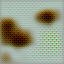

showing /kaggle/working/generated_img_101_0.png


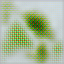

showing /kaggle/working/generated_img_096_0.png


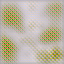

showing /kaggle/working/generated_img_104_0.png


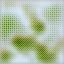

showing /kaggle/working/generated_img_110_0.png


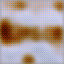

showing /kaggle/working/generated_img_090_0.png


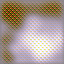

showing /kaggle/working/generated_img_121_1.png


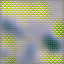

showing /kaggle/working/generated_img_125_1.png


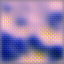

showing /kaggle/working/generated_img_031_1.png


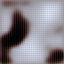

showing /kaggle/working/generated_img_095_0.png


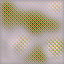

showing /kaggle/working/generated_img_036_0.png


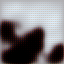

showing /kaggle/working/generated_img_015_0.png


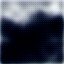

showing /kaggle/working/generated_img_018_1.png


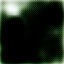

showing /kaggle/working/generated_img_044_1.png


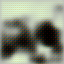

showing /kaggle/working/generated_img_052_0.png


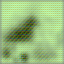

showing /kaggle/working/generated_img_060_1.png


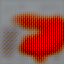

showing /kaggle/working/generated_img_111_0.png


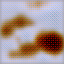

showing /kaggle/working/generated_img_047_1.png


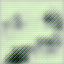

showing /kaggle/working/generated_img_061_0.png


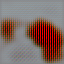

showing /kaggle/working/generated_img_033_1.png


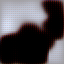

showing /kaggle/working/generated_img_089_0.png


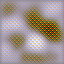

showing /kaggle/working/generated_img_020_1.png


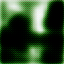

showing /kaggle/working/generated_img_039_0.png


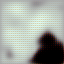

showing /kaggle/working/generated_img_085_1.png


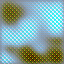

showing /kaggle/working/generated_img_124_0.png


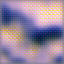

showing /kaggle/working/generated_img_076_1.png


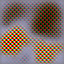

showing /kaggle/working/generated_img_075_1.png


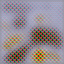

showing /kaggle/working/generated_img_100_1.png


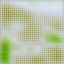

showing /kaggle/working/generated_img_096_1.png


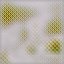

showing /kaggle/working/generated_img_054_1.png


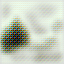

showing /kaggle/working/generated_img_084_1.png


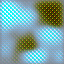

showing /kaggle/working/generated_img_019_1.png


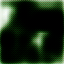

showing /kaggle/working/generated_img_120_0.png


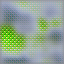

showing /kaggle/working/generated_img_066_1.png


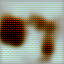

showing /kaggle/working/generated_img_054_0.png


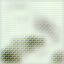

showing /kaggle/working/generated_img_099_1.png


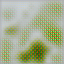

showing /kaggle/working/generated_img_117_0.png


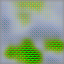

showing /kaggle/working/generated_img_024_0.png


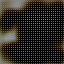

showing /kaggle/working/generated_img_123_1.png


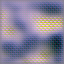

showing /kaggle/working/generated_img_074_1.png


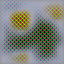

showing /kaggle/working/generated_img_088_0.png


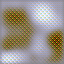

In [15]:
# show some mid-training results
for filename in os.scandir("/kaggle/working"):
    if filename.is_file():
        if len(filename.path.split("."))>1 and filename.path.split(".")[1] == "png":
                print("showing", filename.path)
                display(Image(filename=filename.path))

In [16]:
! mkdir output
! rm output/*.png

rm: cannot remove 'output/*.png': No such file or directory


In [17]:
# generate some results for submission

def generate(gan, num_img):
        random_latent_vectors = tf.random.normal(shape=(num_img, 64))
        generated_images = gan.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("output/output_img_%d.jpg" % (i))

generate(gan, 7)

In [18]:
# show some mid-training results
for filename in os.scandir("/kaggle/working/output"):
    if filename.is_file():
        if len(filename.path.split("."))>1 and filename.path.split(".")[1] == "png":
            print("showing", filename.path)
            display(Image(filename=filename.path))

In [19]:
for i in range(140):
    generate(gan, 50)

In [20]:
! zip images.zip output/*

  adding: output/output_img_0.jpg (deflated 9%)
  adding: output/output_img_1.jpg (deflated 9%)
  adding: output/output_img_10.jpg (deflated 9%)
  adding: output/output_img_11.jpg (deflated 10%)
  adding: output/output_img_12.jpg (deflated 9%)
  adding: output/output_img_13.jpg (deflated 9%)
  adding: output/output_img_14.jpg (deflated 9%)
  adding: output/output_img_15.jpg (deflated 9%)
  adding: output/output_img_16.jpg (deflated 10%)
  adding: output/output_img_17.jpg (deflated 9%)
  adding: output/output_img_18.jpg (deflated 9%)
  adding: output/output_img_19.jpg (deflated 9%)
  adding: output/output_img_2.jpg (deflated 9%)
  adding: output/output_img_20.jpg (deflated 10%)
  adding: output/output_img_21.jpg (deflated 9%)
  adding: output/output_img_22.jpg (deflated 9%)
  adding: output/output_img_23.jpg (deflated 9%)
  adding: output/output_img_24.jpg (deflated 9%)
  adding: output/output_img_25.jpg (deflated 9%)
  adding: output/output_img_26.jpg (deflated 9%)
  adding: output/out

# Conclusions
This seems to just make "splotchy" images in a few colors. This may be an essence of monet's work, but is quite unconvincing. I don't think more epochs or hyperparameter tuning will help substantially here.
As a result, in part 2, I'm trying to use a cycle gan architecture.